<a href="https://colab.research.google.com/github/abdellah-idris/NLI/blob/master/cross%2Bhierarchical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

rendu: zip

final: fcihier a anoter ( text et mettre les labels)

repport : pdf, on vas dans le concret ( moins de blabla)
  -  carnet d'experience ( ce qu'on a tester)
  -  expliciter ce qui n'a pas marché
  -  essayer de faire des conclusion

Presentation:
  - parler d'un truc intéressant et parler rapidement (cross vs grip) 5 a 10 max


date d'envoi max 04/07
mail : @universite-paris-saclay

### **1. Importation des librairies**

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from collections import Counter

### **2. Lecture des données**

In [ ]:
# from google.colab import files

# uploaded = files.upload()

In [ ]:
df = pd.read_csv('train.txt', sep='\t', header=None)

In [ ]:
df

,0
0,(GER) IThe importance and popularity of travel...
1,"(TUR) It is an important decision , how to pla..."
2,(CHI) Some people believe that young people ca...
3,(TEL) Travelling is usually considered as good...
4,(ARA) i agree that . Life is a person live per...
...,...
9895,"(CHI) Nowadays , more and more people go abroa..."
9896,(KOR) In accomplishing something that is risky...
9897,"(SPA) At the beginning of the 21st century , t..."
9898,(HIN) The number of cars in use across the wor...


### **Utils**

#### models & vectorizers + group mapping

In [ ]:
groups_mapping= {'HIN+TEL':0, 'KOR+CHI+JPN':1, 'FRE+SPA+ITA+GER':2,'ARA+TUR':3}

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# vectorizers
vectorizers = {
  # 'vectorizer_BOW' : CountVectorizer(), # default=(1, 1)
  # 'vectorizer_TF_IDF' : TfidfVectorizer(), #default=(1, 1)
  'vectorizer_BOW_bigram' : CountVectorizer(ngram_range=(1, 2)),
  # 'vectorizer_TF_IDF_bigram' : TfidfVectorizer(ngram_range=(1, 2)),
}

# Modèles de classification
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, n_jobs=-1),
    # 'SVM': SVC(),
    # 'rf': RandomForestClassifier(random_state=42, min_samples_split=5, min_samples_leaf=2,  n_jobs=-1)

}

#### Balance data
- each group same number of item
- in each group: each country same number of item

In [ ]:
import pandas as pd

def balance_dataset_groups(df):
    balanced_df = pd.DataFrame(columns=df.columns)

    # Determine the minimum number of samples among all groups
    min_samples_per_group = df['group'].value_counts().min()

    # Iterate over each group in the dataset
    for group_name, group_data in df.groupby('group'):
        # Sample the minimum number of samples for this group
        sampled_group_data = group_data.sample(min_samples_per_group, replace=False)

        # Determine the minimum number of samples among all subgroups within this group
        min_samples_per_subgroup = min_samples_per_group // len(group_data['country_code'].unique())

        # Iterate over each subgroup within this group
        for subgroup_name, subgroup_data in sampled_group_data.groupby('country_code'):
            # Determine the number of samples in this subgroup
            subgroup_size = len(subgroup_data)

            # If the subgroup has fewer samples than required, sample with replacement
            if subgroup_size < min_samples_per_subgroup:
                sampled_subgroup_data = subgroup_data.sample(min_samples_per_subgroup, replace=True)
            else:
                sampled_subgroup_data = subgroup_data.sample(min_samples_per_subgroup, replace=False)

            # Append the sampled subgroup data to the balanced dataset
            balanced_df = pd.concat([balanced_df, sampled_subgroup_data])

    # Reset the index of the balanced DataFrame
    balanced_df.reset_index(drop=True, inplace=True)

    return balanced_df


#### Fonctions d'évaluations et matrice de confusion :

In [ ]:
# from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# def evaluate_model_performance_detailed(mapping_list, model, model_name, method_name, train, test, y_train, y_test):
#     model.fit(train, y_train)
#     predictions = model.predict(test)
#     predictions_train = model.predict(train)


#     # Metrics for each label
#     precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average=None)
#     metrics_df = pd.DataFrame({'Label': list(mapping_list.keys()),
#                                'Precision': precision,
#                                'Recall': recall,
#                                'F1 Score': f1})

#     # Global (macro) metrics
#     precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, predictions, average='macro')
#     accuracy = accuracy_score(y_test, predictions)

#     precision_macro_train , recall_macro_train , f1_macro_train , _ = precision_recall_fscore_support(y_train, predictions_train, average='macro')

#     accuracy_train = accuracy_score(y_train, predictions_train)

#     print("train-------------------------------------------")
#     print(f"{model_name} ({method_name}) - Overall Metrics:\n- Accuracy: {accuracy_train:.4f}\n- Precision (Macro): {precision_macro_train:.4f}\n- Recall (Macro): {recall_macro_train:.4f}\n- F1 (Macro): {f1_macro_train:.4f}\n")

#     print("test--------------------------------------------")
#     print(f"{model_name} ({method_name}) - Overall Metrics:\n- Accuracy: {accuracy:.4f}\n- Precision (Macro): {precision_macro:.4f}\n- Recall (Macro): {recall_macro:.4f}\n- F1 (Macro): {f1_macro:.4f}\n")

#     print(f"{model_name} ({method_name}) - Metrics by Label:")
#     print(metrics_df.to_string(index=False))


#     cm = confusion_matrix(y_test, predictions)

#     # Plotting the confusion matrix
#     plt.figure(figsize=(5, 3))
#     sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d', xticklabels=list(mapping_list.keys()), yticklabels=list(mapping_list.keys()))
#     plt.title(f"Confusion Matrix - {model_name} ({method_name})")
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.show()
#     return model


In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def evaluate_model_performance_detailed(mapping_list, model, model_name, method_name, train, test, y_train, y_test):
    model.fit(train, y_train)
    predictions = model.predict(test)
    predictions_train = model.predict(train)

    # Metrics for each label
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average=None)
    metrics_df = pd.DataFrame({'Label': list(mapping_list.keys()),
                               'Precision': precision,
                               'Recall': recall,
                               'F1 Score': f1})

    # Global (macro) metrics
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, predictions, average='macro')
    accuracy = accuracy_score(y_test, predictions)

    precision_macro_train, recall_macro_train, f1_macro_train, _ = precision_recall_fscore_support(y_train, predictions_train, average='macro')

    accuracy_train = accuracy_score(y_train, predictions_train)

    print("train-------------------------------------------")
    print(f"{model_name} ({method_name}) - Overall Metrics:\n- Accuracy: {accuracy_train:.4f}\n- Precision (Macro): {precision_macro_train:.4f}\n- Recall (Macro): {recall_macro_train:.4f}\n- F1 (Macro): {f1_macro_train:.4f}\n")

    print("test--------------------------------------------")
    print(f"{model_name} ({method_name}) - Overall Metrics:\n- Accuracy: {accuracy:.4f}\n- Precision (Macro): {precision_macro:.4f}\n- Recall (Macro): {recall_macro:.4f}\n- F1 (Macro): {f1_macro:.4f}\n")

    print(f"{model_name} ({method_name}) - Metrics by Label:")
    print(metrics_df.to_string(index=False))

    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d', xticklabels=list(mapping_list.keys()), yticklabels=list(mapping_list.keys()))
    plt.title(f"Confusion Matrix - {model_name} ({method_name})")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Plotting learning curve
    title = f"Learning Curve - {model_name} ({method_name})"
    plot_learning_curve(model, title, train, y_train, ylim=(0.7, 1.01), cv=5, n_jobs=-1)

    plt.tight_layout()
    plt.show()

    return model


#### extract country and text

In [ ]:
def extract_country_and_text(row):
    match = re.match(r'\((.*?)\)(.*)', row)
    if match:
        country_code = match.group(1)
        text = match.group(2)
        return pd.Series([country_code, text])
    else:
        return pd.Series(['', row])

df[['country_code', 'text']] = df.iloc[:, 0].apply(extract_country_and_text)

df['country_code'].value_counts()

GER    900
TUR    900
CHI    900
TEL    900
ARA    900
SPA    900
HIN    900
JPN    900
KOR    900
FRE    900
ITA    900
Name: country_code, dtype: int64

In [ ]:
df.head()

,0,country_code,text
0,(GER) IThe importance and popularity of travel...,GER,IThe importance and popularity of travelling ...
1,"(TUR) It is an important decision , how to pla...",TUR,"It is an important decision , how to plan you..."
2,(CHI) Some people believe that young people ca...,CHI,Some people believe that young people can enj...
3,(TEL) Travelling is usually considered as good...,TEL,Travelling is usually considered as good recr...
4,(ARA) i agree that . Life is a person live per...,ARA,i agree that . Life is a person live period o...


#### create groups

In [ ]:
def create_group(df):
  # Créez une nouvelle colonne 'Country_Code_New4' en copiant 'Country_Code'
  df['group'] = df['country_code']

  df.loc[df['country_code'].isin(['TEL', 'HIN']), 'group']  = 'HIN+TEL'
  df.loc[df['country_code'].isin(['KOR', 'CHI','JPN']), 'group'] = 'KOR+CHI+JPN'
  df.loc[df['country_code'].isin(['FRE', 'SPA','ITA','GER']), 'group'] = 'FRE+SPA+ITA+GER'
  df.loc[df['country_code'].isin(['ARA', 'TUR']), 'group'] = 'ARA+TUR'


  return df

In [ ]:
# def create_group(df):
#   # Créez une nouvelle colonne 'Country_Code_New4' en copiant 'Country_Code'
#   df['group'] = df['country_code']

#   df.loc[df['country_code'].isin(['TEL', 'HIN']), 'group']  = 'HIN+TEL'
#   df.loc[df['country_code'].isin(['KOR', 'CHI','JPN']), 'group'] = 'KOR+CHI+JPN'
#   df.loc[df['country_code'].isin(['FRE', 'SPA','ITA','GER']), 'group'] = 'FRE+SPA+ITA+GER'
#   df.loc[df['country_code'].isin(['TUR']), 'group'] = 'TUR'
#   df.loc[df['country_code'].isin(['ARA']), 'group'] = 'ARA'


#   return df

In [ ]:
create_group(df)

,0,country_code,text,group
0,(GER) IThe importance and popularity of travel...,GER,IThe importance and popularity of travelling ...,FRE+SPA+ITA+GER
1,"(TUR) It is an important decision , how to pla...",TUR,"It is an important decision , how to plan you...",ARA+TUR
2,(CHI) Some people believe that young people ca...,CHI,Some people believe that young people can enj...,KOR+CHI+JPN
3,(TEL) Travelling is usually considered as good...,TEL,Travelling is usually considered as good recr...,HIN+TEL
4,(ARA) i agree that . Life is a person live per...,ARA,i agree that . Life is a person live period o...,ARA+TUR
...,...,...,...,...
9895,"(CHI) Nowadays , more and more people go abroa...",CHI,"Nowadays , more and more people go abroad , n...",KOR+CHI+JPN
9896,(KOR) In accomplishing something that is risky...,KOR,In accomplishing something that is risky come...,KOR+CHI+JPN
9897,"(SPA) At the beginning of the 21st century , t...",SPA,"At the beginning of the 21st century , the in...",FRE+SPA+ITA+GER
9898,(HIN) The number of cars in use across the wor...,HIN,The number of cars in use across the world ha...,HIN+TEL


#### groups_dataframes

In [ ]:
# get Dict by groups
def create_groups_dataframes(df):
  groups_labels = {'HIN+TEL', 'KOR+CHI+JPN', 'FRE+SPA+ITA+GER','ARA+TUR'}
  groups_dataframes = {}

  for label in groups_labels:
      label_df = df[df['group'] == label]  # Replace 'label_column' with the actual column name
      groups_dataframes[label] = label_df

  return groups_dataframes

In [ ]:
# get dict by country in each group
def create_1_group_dataframes(my_df, country_labels):
  groups_dataframes = {}
  for label in country_labels:
      label_df = my_df[my_df['country_code'] == label]  # Replace 'label_column' with the actual column name
      groups_dataframes[label] = label_df

  return groups_dataframes

#### shuffle_rows

In [ ]:
def shuffle_rows(dfs): # mélange des données
    i = 0
    for df in dfs:
      dfs[i] = df.sample(frac = 1, random_state=42)
      i += 1

#### train

In [ ]:
def train(mapping_list, df, save_model_vectorizer):
  X = df['text']
  y_grouped4 = df['group'].map(mapping_list)

  # Entraînement et évaluation des modèles
  for model_name, model in models.items():
      for vectorizer_name, vectorizer in vectorizers.items():
          print('========================= Model: {}; vectorizer: {} ========================='.format(model_name, vectorizer))
          train, test, y_train_grouped4, y_test_grouped4 = train_test_split(vectorizer.fit_transform(X), y_grouped4, test_size=0.2, random_state=42)
          model_save = evaluate_model_performance_detailed(groups_mapping, model, model_name, vectorizer_name, train, test, y_train_grouped4, y_test_grouped4)
          save_model_vectorizer[model_name+'-'+vectorizer_name]  = (model_save, vectorizer)

In [ ]:
def train_1_group(mapping_list, df, save_model_vectorizer):
  X = df['text']
  print(X.shape)
  y_grouped4 = df['country_code'].map(mapping_list)
  print(y_grouped4.shape)

  # Entraînement et évaluation des modèles
  for model_name, model in models.items():
      for vectorizer_name, vectorizer in vectorizers.items():
          print('========================= Model: {}; vectorizer: {} ========================='.format(model_name, vectorizer))
          train, test, y_train_grouped4, y_test_grouped4 = train_test_split(vectorizer.fit_transform(X), y_grouped4, test_size=0.2, random_state=42)
          model_save = evaluate_model_performance_detailed(mapping_list, model, model_name, vectorizer_name, train, test, y_train_grouped4, y_test_grouped4)
          save_model_vectorizer[model_name+'-'+vectorizer_name]  = (model_save, vectorizer)

In [ ]:
# used to plot the regulation effect
def train_diffrent_C(mapping_list, df, vectorizer, C_param=np.linspace(0.001, 100, 100)):
    X = df['text']
    y = df['group'].map(mapping_list)

    # list to record the accuracy
    training_accuracy = []
    testing_accuracy = []

    # list to record the error
    training_error = []
    testing_error = []

    # Entraînement et évaluation des modèles
    print('========================= vectorizer: {} ========================='.format(vectorizer))
    X_train, X_test, y_train, y_test = train_test_split(vectorizer.fit_transform(X), y, test_size=0.2, random_state=42)

    # C Hyperparameter
    for C_value in C_param:
        print('C_value: {}'.format(C_value))
        # Logistic Regression
        lr = LogisticRegression(C=C_value, max_iter=2000, n_jobs=-1)
        lr.fit(X_train, y_train)

        # Appending the Accuracy Score
        training_accuracy.append(lr.score(X_train, y_train))
        testing_accuracy.append(lr.score(X_test, y_test))

        # Appending the Error Score
        training_error.append(1 - lr.score(X_train, y_train))
        testing_error.append(1 - lr.score(X_test, y_test))

    return C_param, training_accuracy, testing_accuracy, training_error, testing_error


In [ ]:
def plot_log(X_values, train_values, test_values, Xlabel, ylabel, title):
    plt.semilogx(X_values, train_values, X_values, test_values)
    plt.xlabel(Xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(("Train", "Test"))
    plt.grid()
    plt.show()

#### best model

In [ ]:
def best(results):
  best = max(results, key=lambda key: results[key]['test_accuracy'])
  return best

#### GET tests data

In [ ]:
grouped = df.groupby('country_code')

In [ ]:

# Group your DataFrame by the 'country_code' column

# Initialize an empty list to hold the samples
samples = []

# Iterate over each group, randomly sample 100 rows (if there are at least 100 rows in the group), and append them to the list
for name, group in grouped:
    if len(group) >= 100:
        sample = group.sample(100, random_state=1)  # random_state is for reproducibility
        samples.append(sample)
        # Remove the sampled rows from the original DataFrame
        df.drop(sample.index, inplace=True)
    else:
        print(f'Not enough rows in country {name} to sample 100.')

# Concatenate all samples into a single DataFrame
all_samples = pd.concat(samples)

# Shuffle the DataFrame
all_samples = all_samples.sample(frac=1, random_state=1).reset_index(drop=True)

# Write the DataFrame to a CSV file
all_samples.to_csv('test.csv', index=False)


In [ ]:
# Get the unique countries with the number of items in 'all_samples'
country_counts = all_samples['country_code'].value_counts()

In [ ]:
# Shuffle the DataFrame
all_samples = all_samples.sample(frac=1, random_state=1).reset_index(drop=True)

In [ ]:
all_samples.head()

,0,country_code,text,group
0,(TUR) Although there are some peoples claiming...,TUR,Although there are some peoples claiming impo...,ARA+TUR
1,"(ITA) I agree with this sentence , because if ...",ITA,"I agree with this sentence , because if I do ...",FRE+SPA+ITA+GER
2,(HIN) I agree with the given statement that yo...,HIN,I agree with the given statement that young p...,HIN+TEL
3,(ARA) Acutly I disagree that becouse if tha st...,ARA,Acutly I disagree that becouse if tha student...,ARA+TUR
4,(CHI) Will we success if we always make a deci...,CHI,Will we success if we always make a decision ...,KOR+CHI+JPN


In [ ]:
# Get the unique groups with the number of items in 'all_samples'
all_samples['country_code'].value_counts()

TUR    100
ITA    100
HIN    100
ARA    100
CHI    100
GER    100
TEL    100
SPA    100
KOR    100
JPN    100
FRE    100
Name: country_code, dtype: int64

In [ ]:
from google.colab import files

# Write the DataFrame to a CSV file in the Colab filesystem
all_samples.to_csv('/content/test.csv', index=False)

##  **3. Regroupement**:

  - **Groupe 01**: TEL, HIN
  - **Groupe 02**: KOR, CHI, JPN
  - **Groupe 03**: FRE, SPA, ITA, GER
  - **Groupe 04**: ARA, TUR

#### Unbalanced

In [ ]:
unbalanced_models = {}
train(groups_mapping, df, unbalanced_models)

========================= Model: Logistic Regression; vectorizer: CountVectorizer(ngram_range=(1, 2)) =========================
train-------------------------------------------
Logistic Regression (vectorizer_BOW_bigram) - Overall Metrics:
- Accuracy: 1.0000
- Precision (Macro): 1.0000
- Recall (Macro): 1.0000
- F1 (Macro): 1.0000

test--------------------------------------------
Logistic Regression (vectorizer_BOW_bigram) - Overall Metrics:
- Accuracy: 0.8869
- Precision (Macro): 0.8813
- Recall (Macro): 0.8655
- F1 (Macro): 0.8724

Logistic Regression (vectorizer_BOW_bigram) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.945860 0.894578  0.919505
    KOR+CHI+JPN   0.874251 0.918239  0.895706
FRE+SPA+ITA+GER   0.897989 0.931446  0.914411
        ARA+TUR   0.807229 0.717857  0.759924


.Best model

In [ ]:
unbalanced_models

{'rf-vectorizer_BOW_bigram': (RandomForestClassifier(random_state=42),
  CountVectorizer(ngram_range=(1, 2)))}

#### Balanced

In [ ]:
# Balance the dataset
balanced_df = balance_dataset_groups(df)

# Verify the balance
print(balanced_df['group'].value_counts())
print(balanced_df.groupby(['group', 'country_code']).size())

ARA+TUR            1600
FRE+SPA+ITA+GER    1600
HIN+TEL            1600
KOR+CHI+JPN        1599
Name: group, dtype: int64
group            country_code
ARA+TUR          ARA             800
                 TUR             800
FRE+SPA+ITA+GER  FRE             400
                 GER             400
                 ITA             400
                 SPA             400
HIN+TEL          HIN             800
                 TEL             800
KOR+CHI+JPN      CHI             533
                 JPN             533
                 KOR             533
dtype: int64


========================= Model: rf; vectorizer: CountVectorizer(ngram_range=(1, 2)) =========================
train accuracy 0.8295809881175735 
rf (vectorizer_BOW_bigram) - Overall Metrics:
- Accuracy: 0.6663
- Precision (Macro): 0.6734
- Recall (Macro): 0.6669
- F1 (Macro): 0.6611

rf (vectorizer_BOW_bigram) - Metrics by Label:
          Label  Precision   Recall  F1 Score
        HIN+TEL   0.651163 0.875000  0.746667
    KOR+CHI+JPN   0.635294 0.696774  0.664615
FRE+SPA+ITA+GER   0.676829 0.676829  0.676829
            TUR   0.615942 0.559211  0.586207
            ARA   0.787611 0.526627  0.631206


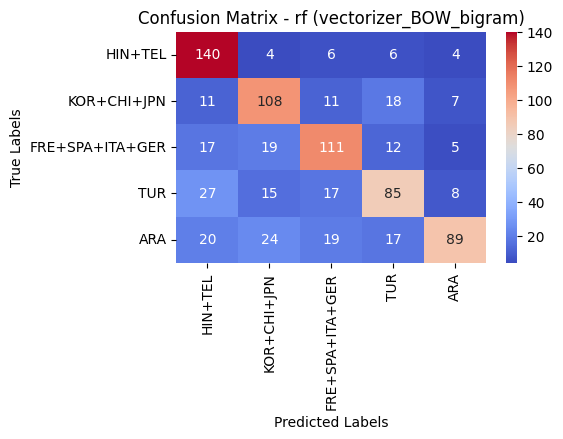

In [ ]:
balanced_models = {}
train(groups_mapping, balanced_df, balanced_models)

In [ ]:
balanced_models

{'rf-vectorizer_BOW_bigram': (RandomForestClassifier(random_state=42),
  CountVectorizer(ngram_range=(1, 2)))}

#### Test C param

In [ ]:
df.head()

,0,country_code,text,group
0,(GER) IThe importance and popularity of travel...,GER,IThe importance and popularity of travelling ...,FRE+SPA+ITA+GER
1,"(TUR) It is an important decision , how to pla...",TUR,"It is an important decision , how to plan you...",ARA+TUR
2,(CHI) Some people believe that young people ca...,CHI,Some people believe that young people can enj...,KOR+CHI+JPN
3,(TEL) Travelling is usually considered as good...,TEL,Travelling is usually considered as good recr...,HIN+TEL
4,(ARA) i agree that . Life is a person live per...,ARA,i agree that . Life is a person live period o...,ARA+TUR


In [ ]:
# C_param, training_accuracy, testing_accuracy, training_error, testing_error = train_diffrent_C(groups_mapping, df, vectorizers['vectorizer_BOW_bigram'], [0.001,0.01,1,10])

In [ ]:
# plot_log(C_param, training_accuracy, testing_accuracy, "C Values", "Accuracy", "Logistic Regression Accuracy with varying C values")

In [ ]:
#plot_log(C_param, training_error, testing_error, "C Values", "Error", "Logistic Regression Errors with varying C values")

# 4. cross validation functions

##### Create groups dataframes

In [ ]:
balanced_df.head() # groups are balanced

,0,country_code,text,group
0,(ARA) Some people believe that it is important...,ARA,Some people believe that it is important to h...,ARA+TUR
1,"(ARA) In the past , knowledge was not valued a...",ARA,"In the past , knowledge was not valued and sp...",ARA+TUR
2,(ARA) i agree with the best way to travel is i...,ARA,i agree with the best way to travel is in a g...,ARA+TUR
3,(ARA) The young people are considered very imp...,ARA,The young people are considered very importan...,ARA+TUR
4,"(ARA) Nowedays , competition between companies...",ARA,"Nowedays , competition between companies is f...",ARA+TUR


In [ ]:
df # groups are not balanced

,0,country_code,text,group
0,(GER) IThe importance and popularity of travel...,GER,IThe importance and popularity of travelling ...,FRE+SPA+ITA+GER
1,"(TUR) It is an important decision , how to pla...",TUR,"It is an important decision , how to plan you...",ARA+TUR
2,(CHI) Some people believe that young people ca...,CHI,Some people believe that young people can enj...,KOR+CHI+JPN
3,(TEL) Travelling is usually considered as good...,TEL,Travelling is usually considered as good recr...,HIN+TEL
4,(ARA) i agree that . Life is a person live per...,ARA,i agree that . Life is a person live period o...,ARA+TUR
...,...,...,...,...
9895,"(CHI) Nowadays , more and more people go abroa...",CHI,"Nowadays , more and more people go abroad , n...",KOR+CHI+JPN
9896,(KOR) In accomplishing something that is risky...,KOR,In accomplishing something that is risky come...,KOR+CHI+JPN
9897,"(SPA) At the beginning of the 21st century , t...",SPA,"At the beginning of the 21st century , the in...",FRE+SPA+ITA+GER
9898,(HIN) The number of cars in use across the wor...,HIN,The number of cars in use across the world ha...,HIN+TEL


In [ ]:
labels = {"GER","TUR","CHI","TEL","ARA","SPA","HIN","JPN","KOR","FRE","ITA"}

In [ ]:
label_dataframes = {}

for label in labels:
    label_df = df[df['country_code'] == label]  # Replace 'label_column' with the actual column name
    label_dataframes[label] = label_df

In [ ]:
label_dataframes.keys()

dict_keys(['TUR', 'JPN', 'TEL', 'KOR', 'ITA', 'ARA', 'GER', 'SPA', 'HIN', 'FRE', 'CHI'])

In [ ]:
groups_df = create_groups_dataframes(df)

In [ ]:
groups_df.keys()

dict_keys(['HIN+TEL', 'KOR+CHI+JPN', 'ARA+TUR', 'FRE+SPA+ITA+GER'])

In [ ]:
groups_df['HIN+TEL'].shape

(1600, 4)

In [ ]:
groups_df['FRE+SPA+ITA+GER'].shape

(3200, 4)

##### splits

In [ ]:
def splits(label_dataframes, split_nbr):
    size = 1800
    max = 100

    trains = []
    devs = []
    tests = []

    start = 0
    end = size // split_nbr if split_nbr != 0 and size // split_nbr < max else max

    while split_nbr != 0:
        split_nbr -= 1

        train_splits = []
        dev_splits = []
        test_splits = []

        for df in label_dataframes.values():
            test_split = df[start:end]
            dev_split = df[end:end + (end - start)]  # Set dev_split size to (end - start)
            train_split = df[end + (end - start):]    # The remaining data goes to test_split

            train_splits.append(train_split)
            dev_splits.append(dev_split)
            test_splits.append(test_split)

        trains.append(pd.concat(train_splits))
        devs.append(pd.concat(dev_splits))
        tests.append(pd.concat(test_splits))

        start = end
        end = start + (size // split_nbr) if split_nbr != 0 and (size // split_nbr) < max else (start + max)

    return trains, devs, tests


##### test indexes

In [ ]:
def test_diffrent_indexes(dfs):
    # Initialize a variable to track if indexes are different
    different_indexes = False

    # Iterate through pairs of DataFrames and compare indexes
    for i in range(len(dfs) - 1):
        for j in range(i + 1, len(dfs)):
            if not dfs[i].index.equals(dfs[j].index):
                different_indexes = True
                break
        if different_indexes:
            break

    # Output the result
    if different_indexes:
        print("The DataFrames have different indexes.")
    else:
        print("The DataFrames have the same indexes.")

In [ ]:
trains, devs, tests = splits(groups_df, 3)

In [ ]:
test_diffrent_indexes(devs), test_diffrent_indexes(tests)

The DataFrames have different indexes.
The DataFrames have different indexes.


(None, None)

In [ ]:
shuffle_rows(trains), shuffle_rows(tests), shuffle_rows(devs)

(None, None, None)

In [ ]:
trains[0].shape[0], devs[0].shape[0], tests[0].shape[0],

(8000, 400, 400)

##### cross validation

In [ ]:
from sklearn.model_selection import cross_val_score, ParameterGrid
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import time

def cross_validation(mapping_list, df, model, params, vectorizer, split=3):
    # split data: train, dev, test
    trains, devs, tests = splits(df, split)

    param_grid = ParameterGrid(params)
    results = {}

    for param in param_grid:
        iteration = 0
        accuracies = []
        test_accuracies=[]
        print(param)

        model.set_params(**param)  # set model parameters
        print(model)

        for train, dev, test in zip(trains, devs, tests):
            start = time.time()
            iteration += 1
            print(iteration)

            # Feature extraction for text
            vectorizer.fit(train['text'])
            X_train_text = vectorizer.transform(train['text'])
            X_dev_text = vectorizer.transform(dev['text'])
            X_test_text = vectorizer.transform(test['text'])


            # Train the model on the training set
            model.fit(X_train_text, train['group'].map(mapping_list))

            # Validate the model on the dev set
            accuracy = model.score(X_dev_text, dev['group'].map(mapping_list))
            accuracies.append(accuracy)

            # Evaluate the model on the test set
            test_accuracy = model.score(X_test_text, test['group'].map(mapping_list))
            test_accuracies.append(test_accuracy)

            print("Dev Accuracy= " + str(accuracy))
            print("Test Accuracy= " + str(test_accuracy))
            print("time spent=" + str((time.time()-start)/60))

        results[str(param)] = {
            "model": model.set_params(**param),
            "vectorizer": vectorizer,
            'dev_mean_accuracy': sum(accuracies) / len(accuracies),
            'test_accuracy': sum(test_accuracies) / len(test_accuracies),
        }

    return results

In [ ]:
def cross_validation_1group(mapping_list, df, model, params, vectorizer, split=3):
    df.keys()
    # split data: train, dev, test
    trains, devs, tests = splits(df, split)

    param_grid = ParameterGrid(params)
    results = {}

    for param in param_grid:
        iteration = 0
        accuracies = []
        test_accuracies=[]
        print(param)

        # Train the model on the training set
        model.set_params(**param)  # set model parameters
        print(model)

        for train, dev, test in zip(trains, devs, tests):
            start = time.time()
            iteration += 1
            print(iteration)

            # Feature extraction for text
            vectorizer.fit(train['text'])
            X_train_text = vectorizer.transform(train['text'])
            X_dev_text = vectorizer.transform(dev['text'])
            X_test_text = vectorizer.transform(test['text'])


            model.fit(X_train_text, train['country_code'].map(mapping_list))

            # Validate the model on the dev set
            accuracy = model.score(X_dev_text, dev['country_code'].map(mapping_list))
            accuracies.append(accuracy)

            # Evaluate the model on the test set
            test_accuracy = model.score(X_test_text, test['country_code'].map(mapping_list))
            test_accuracies.append(test_accuracy)

            print("Dev Accuracy= " + str(accuracy))
            print("Test Accuracy= " + str(test_accuracy))
            print("time spent=" + str((time.time()-start)/60))

        results[str(param)] = {
            "model": model.set_params(**param),
            "vectorizer": vectorizer,
            'dev_mean_accuracy': sum(accuracies) / len(accuracies),
            'test_accuracy': sum(test_accuracies) / len(test_accuracies),
        }

    return results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

def plot_grid_search_curve(estimator, X, y, param_grid, title, scoring='accuracy', cv=3):
    grid_search = GridSearchCV(estimator, param_grid, scoring=scoring, cv=cv)
    grid_search.fit(X, y)

    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    params = grid_search.cv_results_['params']

    plt.figure()
    plt.title(title)
    plt.xlabel("Parameter Combinations")
    plt.ylabel("Score")
    plt.grid()

    xticks = [str(params[i]) for i in range(len(params))]
    plt.xticks(rotation=90)

    plt.errorbar(range(len(means)), means, yerr=stds, fmt='o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

##### save & load model

In [ ]:
import pickle

def save_model_vectorizer(model, vectorizer, model_name, vectorizer_name):
    pickle.dump(model, open(model_name, 'wb'))
    pickle.dump(vectorizer, open(vectorizer_name, 'wb'))

In [ ]:
def load(filename):
    return  pickle.load(open(filename, 'rb'))

# 5. Cross validation first model M1

## Grids and models

In [ ]:
lr_model = LogisticRegression()
lr_param_grid = {
    'penalty': ['l2','elasticnet'],  # Regularization penalty
    'C': [0.01, 10],  # Inverse regularization strength (reduced to two values)
    'solver': ['saga'],  # Algorithm to use in the optimization problem
    'max_iter': [2000],  # Maximum number of iterations (reduced to one value)
    'n_jobs': [-1],
    'l1_ratio': [0.01, 0.1]
}

##LogisticRegression



#### Grid sarech

In [ ]:
# X = vectorizers['vectorizer_BOW_bigram'].fit_transform(df['text'])
# y = df['group'].map(groups_mapping)

In [ ]:
# plot_grid_search_curve(lr_model, X, y, lr_param_grid, "Logistic Regression Grid search Cross Validation Curve", scoring='accuracy', cv=2)
# plt.show()

#### cross

In [ ]:
results = cross_validation(groups_mapping, groups_df, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

{'C': 0.01, 'l1_ratio': 0.01, 'max_iter': 2000, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'saga'}
LogisticRegression(C=0.01, l1_ratio=0.01, max_iter=2000, n_jobs=-1,
                   solver='saga')
1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Dev Accuracy= 0.83
Test Accuracy= 0.825
time spent=2.463172805309296
2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Dev Accuracy= 0.8
Test Accuracy= 0.82
time spent=1.9034225821495057
{'C': 0.01, 'l1_ratio': 0.01, 'max_iter': 2000, 'n_jobs': -1, 'penalty': 'elasticnet', 'solver': 'saga'}
LogisticRegression(C=0.01, l1_ratio=0.01, max_iter=2000, n_jobs=-1,
                   penalty='elasticnet', solver='saga')
1
Dev Accuracy= 0.8425
Test Accuracy= 0.825
time spent=15.32566233476003
2
Dev Accuracy= 0.815
Test Accuracy= 0.8275
time spent=14.590993177890777
{'C': 0.01, 'l1_ratio': 0.1, 'max_iter': 2000, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'saga'}
LogisticRegression(C=0.01, l1_ratio=0.1, max_iter=2000, n_jobs=-1,
                   solver='saga')
1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Dev Accuracy= 0.8325
Test Accuracy= 0.825
time spent=2.114786728223165
2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Dev Accuracy= 0.8
Test Accuracy= 0.82
time spent=1.9540027817090353
{'C': 0.01, 'l1_ratio': 0.1, 'max_iter': 2000, 'n_jobs': -1, 'penalty': 'elasticnet', 'solver': 'saga'}
LogisticRegression(C=0.01, l1_ratio=0.1, max_iter=2000, n_jobs=-1,
                   penalty='elasticnet', solver='saga')
1
Dev Accuracy= 0.7925
Test Accuracy= 0.8
time spent=6.135742755730947
2
Dev Accuracy= 0.77
Test Accuracy= 0.78
time spent=5.6530538161595665
{'C': 10, 'l1_ratio': 0.01, 'max_iter': 2000, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'saga'}
LogisticRegression(C=10, l1_ratio=0.01, max_iter=2000, n_jobs=-1, solver='saga')
1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Dev Accuracy= 0.8625
Test Accuracy= 0.84
time spent=16.203991866111757
2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


In [ ]:
results

In [ ]:
# Resultas de la cross validation


In [ ]:
# Find the key with the best test accuracy
best_accuracy_key = max(results, key=lambda key: results[key]['test_accuracy'])
print("Key with best test accuracy:", best_accuracy_key)

In [ ]:
results[best_accuracy_key]["test_accuracy"]

In [ ]:
# cross validation model
M1 = results[best_accuracy_key]["model"]
V1 = results[best_accuracy_key]["vectorizer"]

In [ ]:
save_model_vectorizer(M1, V1, "M1.sav", "V1.pkl")

# Cross validation specialized model M2

## Utils

#### extract groups

In [ ]:
def extract_group(df, group):
  return df[df['group'] == group]

### mapping country

In [ ]:
def mapping(df, mapping):
  df['country_code'].map(mapping)

#### create data frame for each group

In [ ]:
df_g1 = extract_group(df, 'HIN+TEL')

In [ ]:
df_g1

In [ ]:
df_g2 = extract_group(df,'KOR+CHI+JPN')

In [ ]:
df_g2.head()

In [ ]:
df_g3 = extract_group(df, 'FRE+SPA+ITA+GER')

## Model for  Groupe 1 HIN+TEL without other


#### train

In [ ]:
models_g1 = {}
mapping_list1 = {'HIN':0,'TEL':1}
train_1_group(mapping_list1, df_g1, models_g1) # mapping is done here

### cross

In [ ]:
dict_df1 = create_1_group_dataframes(balanced_df, {'HIN', 'TEL'})

In [ ]:
results = cross_validation_1group(mapping_list1, dict_df1, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

In [ ]:
best_accuracy_key = best(results)

In [ ]:
best_accuracy_key

In [ ]:
results[best_accuracy_key]

In [ ]:
best_accuracy_key = best(results)
# cross validation model
M_G1 = results[best_accuracy_key]["model"]
V_G1 = results[best_accuracy_key]["vectorizer"]
save_model_vectorizer(M_G1, V_G1, "M_G1.sav", "V_G1.pkl")

In [ ]:
df_g4 = extract_group(df, 'ARA+TUR')

## Model for  Groupe 2 'KOR+CHI+JPN' without other


#### train

In [ ]:
models_g2 = {}
mapping_list2 = {'KOR':0, 'CHI':1, 'JPN':2}
train_1_group(mapping_list2, df_g2, models_g2) # mapping is done here

### cross

In [ ]:
dict_df2 = create_1_group_dataframes(balanced_df, {'KOR', 'CHI', "JPN"})

In [ ]:
results = cross_validation_1group(mapping_list2, dict_df2, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

In [ ]:
best_accuracy_key = best(results)

In [ ]:
best_accuracy_key

In [ ]:
results[best_accuracy_key]

In [ ]:
# cross validation model
M_G2 = results[best_accuracy_key]["model"]
V_G2 = results[best_accuracy_key]["vectorizer"]
save_model_vectorizer(M_G2, V_G1, "M_G2.sav", "V_G2.pkl")

In [ ]:
results[best_accuracy_key]['test_accuracy']

## Model for  Groupe 3 'FRE+SPA+ITA+'GER' without other



In [ ]:
df_g3.head()

#### train

In [ ]:
models_g3 = {}
mapping_list3 = {'FRE':0,'SPA':1,'ITA':2, 'GER':3 }
train_1_group(mapping_list3, df_g3, models_g3) # mapping is done here

### cross

In [ ]:
dict_df3 = create_1_group_dataframes(balanced_df, {'FRE', 'SPA', "ITA", "GER"})

In [ ]:
results = cross_validation_1group(mapping_list3, dict_df3, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

In [ ]:
best_accuracy_key = best(results)

In [ ]:
best_accuracy_key

In [ ]:
results[best_accuracy_key]

In [ ]:
# cross validation model
M_G3 = results[best_accuracy_key]["model"]
V_G3 = results[best_accuracy_key]["vectorizer"]
save_model_vectorizer(M_G3, V_G3, "M_G3.sav", "V_G3.pkl")

In [ ]:
results[best_accuracy_key]['test_accuracy']

## Model for  Groupe 4 ARA+TUR without other

In [ ]:
df_g4.head()

#### train

In [ ]:
models_g4 = {}
mapping_list4 = {'ARA':0,'TUR':1}
train_1_group(mapping_list4, df_g4, models_g4) # mapping is done here

### cross

In [ ]:
dict_df4 = create_1_group_dataframes(balanced_df, {'ARA', 'TUR'})

In [ ]:
dict_df4

In [ ]:
results = cross_validation_1group(mapping_list4, dict_df4, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

In [ ]:
best_accuracy_key = best(results)

In [ ]:
best_accuracy_key

In [ ]:
results

In [ ]:
results[best_accuracy_key]

In [ ]:
# cross validation model
M_G4 = results[best_accuracy_key]["model"]
V_G4 = results[best_accuracy_key]["vectorizer"]
save_model_vectorizer(M_G4, V_G4, "M_G4.sav", "V_G4.pkl")

In [ ]:
results

# Other

## Utils

In [ ]:
label_dataframes.keys()

In [ ]:
def get_others(label_dataframes, labels_to_skip, size):
  keys_count = 11 - len(labels_to_skip)
  items_count_per_key = int(size / keys_count)
  others = []
  for key in label_dataframes.keys():
    if key  in labels_to_skip:
      continue
    # Extract text from the DataFrame and replace country_code with "other"
    df = label_dataframes[key].copy()  # Make a copy to avoid modifying the original DataFrame
    df['country_code'] = 'other'
    # Extract first items_count_per_key rows
    df = df.iloc[:items_count_per_key]
    # Append the DataFrame to the list
    others.append(df)
  # Concatenate all DataFrames in the list along the rows
  result_df = pd.concat(others, ignore_index=True)
  return result_df


## Model for  Groupe 1 HIN+TEL

In [ ]:
df_g1.head()

In [ ]:
labels_to_skip = ['HIN', 'TEL']  # List of labels to skip
others_df = get_others(label_dataframes, labels_to_skip, 800)

In [ ]:
concatenated_df1 = pd.concat([df_g1, others_df], ignore_index=True)

In [ ]:
mapping_list1_other = {'HIN':0,'TEL':1, "other":2}

### train

In [ ]:
train_1_group(mapping_list1_other, concatenated_df1, {}) # mapping is done here

### cross

In [ ]:
concatenated_df1

In [ ]:
# Define the order of country labels
country_labels = ['HIN', 'TEL', 'other']

# Call the function with a list instead of a set
dict_df1_other = create_1_group_dataframes(concatenated_df1, country_labels)

# Count the number of items for each country code
counts_dict = {label: len(dict_df1_other[label]) for label in country_labels}

print(counts_dict)


In [ ]:
results = cross_validation_1group(mapping_list1_other, dict_df1_other, lr_model, lr_param_grid, vectorizers['vectorizer_TF_IDF'], 2)

In [ ]:
best_accuracy_key = best(results)

In [ ]:
results[best_accuracy_key]

In [ ]:
# cross validation model
M2_G1 = results[best_accuracy_key]["model"]
V2_G1 = results[best_accuracy_key]["vectorizer"]
save_model_vectorizer(M2_G1, V2_G1, "M2_G1.sav", "V2_G1.pkl")

## Model for  Groupe 2 KOR+JPN+CHI

In [ ]:
df_g2.head()

In [ ]:
labels_to_skip = ['KOR', 'CHI', 'JPN']  # List of labels to skip
others_df = get_others(label_dataframes, labels_to_skip, 800)

In [ ]:
concatenated_df2 = pd.concat([df_g2, others_df], ignore_index=True)

In [ ]:
concatenated_df2

In [ ]:
mapping_list2_other = {'KOR':0, 'CHI':1, 'JPN':2, 'other':3}

### train

In [ ]:
train_1_group(mapping_list2_other, concatenated_df2, {}) # mapping is done here

### cross

In [ ]:
# Define the order of country labels
country_labels = ['KOR','CHI', 'JPN','other']

# Call the function with a list instead of a set
dict_df2_other = create_1_group_dataframes(concatenated_df2, country_labels)

# Count the number of items for each country code
counts_dict = {label: len(dict_df2_other[label]) for label in country_labels}

print(counts_dict)

In [ ]:
dict_df2_other['other']['group'].unique()

In [ ]:
dict_df2_other.keys()

In [ ]:
results = cross_validation_1group(mapping_list2_other, dict_df2_other, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

In [ ]:
best_accuracy_key = best(results)

In [ ]:
results[best_accuracy_key]

In [ ]:
# cross validation model
M2_G2 = results[best_accuracy_key]["model"]
V2_G2 = results[best_accuracy_key]["vectorizer"]
save_model_vectorizer(M2_G2, V2_G2, "M2_G2.sav", "V2_G2.pkl")


## Model for  Groupe 3 'FRE+SPA+ITA+'GER'


In [ ]:
df_g3.head()

In [ ]:
labels_to_skip = ['FRE', 'SPA', 'ITA', 'GER']  # List of labels to skip
others_df = get_others(label_dataframes, labels_to_skip, 800)

In [ ]:
concatenated_df3 = pd.concat([df_g3, others_df], ignore_index=True)

In [ ]:
mapping_list3_other = {'FRE':0,'SPA':1,'ITA':2, 'GER':3, 'other':4 }


### train

In [ ]:
train_1_group(mapping_list3_other, concatenated_df3, {}) # mapping is done here

### cross

In [ ]:
# Define the order of country labels
country_labels = ['FRE', 'SPA', 'ITA', 'GER', 'other']

# Call the function with a list instead of a set
dict_df3_other = create_1_group_dataframes(concatenated_df3, country_labels)

# Count the number of items for each country code
counts_dict = {label: len(dict_df3_other[label]) for label in country_labels}

print(counts_dict)

In [ ]:
dict_df3_other.keys()

In [ ]:
results = cross_validation_1group(mapping_list3_other, dict_df3_other, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

In [ ]:
best_accuracy_key = best(results)

In [ ]:
results[best_accuracy_key]

In [ ]:
# cross validation model
M2_G3 = results[best_accuracy_key]["model"]
V2_G3 = results[best_accuracy_key]["vectorizer"]
save_model_vectorizer(M2_G3, V2_G3, "M2_G3.sav", "V2_G3.pkl")

## Model for  Groupe 4 ARA+TUR

In [ ]:
df_g4.head()

In [ ]:
labels_to_skip = ['ARA', 'TUR']  # List of labels to skip
others_df = get_others(label_dataframes, labels_to_skip, 800)

In [ ]:
concatenated_df4 = pd.concat([df_g4, others_df], ignore_index=True)

In [ ]:
mapping_list4_other = {'ARA':0,'TUR':1, 'other':2}

### train

In [ ]:
train_1_group(mapping_list4_other, concatenated_df4, {}) # mapping is done here

### cross

In [ ]:
# Define the order of country labels
country_labels = ['ARA', 'TUR', 'other']

# Call the function with a list instead of a set
dict_df4_other = create_1_group_dataframes(concatenated_df4, country_labels)

# Count the number of items for each country code
counts_dict = {label: len(dict_df4_other[label]) for label in country_labels}

print(counts_dict)

In [ ]:
dict_df4_other.keys()

In [ ]:
dict_df4_other

In [ ]:
results = cross_validation_1group(mapping_list4_other, dict_df4_other, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

In [ ]:
best_accuracy_key = best(results)

In [ ]:
results[best_accuracy_key]

In [ ]:
# cross validation model
M2_G4 = results[best_accuracy_key]["model"]
V2_G4 = results[best_accuracy_key]["vectorizer"]
save_model_vectorizer(M2_G4, V2_G4, "M2_G4.sav", "V2_G4.pkl")

# M3

## M3 GRIDS

In [ ]:
lr_model = LogisticRegression()
lr_param_grid = {
    'penalty': ['l2'],  # Regularization penalty
    'C': [0.1, 1],  # Inverse regularization strength (reduced to two values)
    'solver': ['liblinear', 'saga'],  # Algorithm to use in the optimization problem
    'max_iter': [3000],  # Maximum number of iterations (reduced to one value)
    'tol': [1e-4]  # Tolerance for stopping criteria (only one value)
}

In [ ]:
mapping_list = {'HIN' :0, 'TEL':1, 'KOR':2, 'JPN': 3, 'CHI' : 4, 'FRE' :5, 'SPA':6, 'ITA': 7, 'GER':8, 'ARA':9, 'TUR':10}

In [ ]:
df[['country_code', 'text']] = df.iloc[:, 0].apply(extract_country_and_text)

In [ ]:
df.head()

## train

In [ ]:
train_1_group(mapping_list, df, {})

## cross

In [ ]:
label_dataframes.keys()

In [ ]:
for key, value in label_dataframes.items():
    print(f"Size of {key}: {len(value)}")

In [ ]:
mapping_list = {'HIN' :0, 'TEL':1, 'KOR':2, 'JPN': 3, 'CHI' : 4, 'FRE' :5, 'SPA':6, 'ITA': 7, 'GER':8, 'ARA':9, 'TUR':10}

In [ ]:
results = cross_validation_1group(mapping_list, label_dataframes, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

## save

In [ ]:
best_accuracy_key = best(results)

In [ ]:
results[best_accuracy_key]

In [ ]:
# cross validation model
M3 = results[best_accuracy_key]["model"]
V3 = results[best_accuracy_key]["vectorizer"]
save_model_vectorizer(M3, V3, "M3.sav", "V3.pkl")